In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import gensim.downloader as api
from gensim.models import KeyedVectors
from datasets import load_dataset, Dataset

# Dataset

In [28]:
nope_ds = load_dataset("tasksource/nope",split="train")
nope_ds 

Repo card metadata block was not found. Setting CardData to empty.


Dataset({
    features: ['uid', 'premise', 'hypothesis', 'label', 'metadata'],
    num_rows: 2386
})

In [29]:
train_df = nope_ds.to_pandas()
train_df = train_df[['premise','hypothesis','label']]
train_df

,premise,hypothesis,label
0,The cops had him in their headlights. He ran h...,He was standing earlier.,E
1,The cops had him in their headlights. He ran h...,He was standing earlier.,E
2,For three nights a comet flared through the de...,A red smudge couldn't be seen on the moon before.,E
3,For three nights a comet flared through the de...,A red smudge couldn't be seen on the moon before.,E
4,""" He just thinks it's so much bull--. He's not...",We are someone.,N
...,...,...,...
2381,I've worked obviously suspicious gobblers for ...,They will react in some way.,E
2382,"And, of course, at that time my dad was dying,...",Something happened.,E
2383,"And, of course, at that time my dad was dying,...",Something happened.,E
2384,I felt grubby just looking at her. I don't kn...,Elissa has a favorite hobby.,N


In [7]:
valid_df = pd.read_csv('/kaggle/input/nli-data/new_valid_all.csv',index_col=0)
valid_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,gold_label,type
9600.0,"If Jessica attends the conference, her colleag...",Jessica has a colleague.,E,type5_possessive
9601.0,It's not the case that if Jessica attends the ...,Jessica has a colleague.,E,type5_possessive
9602.0,Sam believes that if Jessica attends the confe...,Jessica has a colleague.,E,type5_possessive
9603.0,Is it true that if Jessica attends the confere...,Jessica has a colleague.,E,type5_possessive
9620.0,"If Mia's car breaks down, her coworker will gi...",Mia has a coworker.,E,type5_possessive
...,...,...,...,...
NaN,"If Margaret graduates from college, her parent...",Margaret has siblings.,N,type5_possessive
NaN,It's not the case that if Margaret graduates f...,Margaret has siblings.,N,type5_possessive
NaN,Sam believes that if Margaret graduates from c...,Margaret has siblings.,N,type5_possessive
NaN,Is it true that if Margaret graduates from col...,Margaret has siblings.,N,type5_possessive


In [8]:
test_df = pd.read_csv('/kaggle/input/nli-data/new_test_all.csv',index_col=0)
test_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,gold_label,type
9616.0,"If Charlotte passes her driving test, her pare...",Charlotte has parents.,E,type5_possessive
9617.0,It's not the case that if Charlotte passes her...,Charlotte has parents.,E,type5_possessive
9618.0,Sam believes that if Charlotte passes her driv...,Charlotte has parents.,E,type5_possessive
9619.0,Is it true that if Charlotte passes her drivin...,Charlotte has parents.,E,type5_possessive
9628.0,"If Lily takes the train to the city, her frien...",Lily has a friend.,E,type5_possessive
...,...,...,...,...
NaN,"If Sophia decides to attend the concert, his b...",Sophia has a close friend.,N,type5_possessive
NaN,It's not the case that if Sophia decides to at...,Sophia has a close friend.,N,type5_possessive
NaN,Sam believes that if Sophia decides to attend ...,Sophia has a close friend.,N,type5_possessive
NaN,Is it true that if Sophia decides to attend th...,Sophia has a close friend.,N,type5_possessive


In [9]:
train_df['premise'].isna().sum()

0

In [10]:
train_df['hypothesis'].isna().sum()

0

In [11]:
train_df[train_df['hypothesis'].isna()]

,premise,hypothesis,label


In [12]:
train_df.loc[train_df['hypothesis'].isna(), 'hypothesis'] = "Martin has incited a response before"

In [13]:
train_df[train_df['hypothesis'].isna()]

,premise,hypothesis,label


In [15]:
train_df['label'].value_counts()

label
N    174
C    119
E     53
Name: count, dtype: int64

In [17]:
def encode_infersent_sentence(sentence,model):
    return model.encode([sentence], tokenize=True)[0]

In [18]:
def get_sentence_embedding(row, model, glove):
    premise = row['premise']
    hypothesis = row['hypothesis'] 
    if glove:
        embedded_premise = encode_glove_sentence(premise,model)
        embedded_hypothesis = encode_glove_sentence(hypothesis,model)
    else:
        embedded_premise = encode_infersent_sentence(premise,model)
        embedded_hypothesis = encode_infersent_sentence(hypothesis,model)
    return np.concatenate((embedded_premise, embedded_hypothesis), axis=0)

# InferSent 

In [19]:
import sys

In [20]:
sys.path.append('/kaggle/input/infersent')

In [21]:
sys.path

['/kaggle/working',
 '/kaggle/lib/kagglegym',
 '/kaggle/lib',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor',
 '/root/.ipython',
 '/kaggle/input/infersent']

In [22]:
from models import InferSent
import torch

In [23]:
params_model = {
    'bsize': 64,
    'word_emb_dim': 300,
    'enc_lstm_dim': 2048,
    'pool_type': 'max',
    'dpout_model': 0.0,
    'n_enc_layers': 1,
    'version': 2  # Use version 2 for fastText
}

In [24]:
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load('/kaggle/input/infersent/infersent2.pkl'))
infersent.set_w2v_path('/kaggle/input/infersent/crawl-300d-2M.vec/crawl-300d-2M.vec')

<ipython-input-24-6d0716483458>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  infersent.load_state_dict(torch.load('/kaggle/input/infersent/infersent2.pkl'))


In [25]:
premises = train_df['premise'].tolist()
hypotheses = train_df['hypothesis'].tolist()
all_sentences = premises + hypotheses
len(all_sentences)

692

In [26]:
infersent.build_vocab(all_sentences, tokenize=True)

Found 3003(/3061) words with w2v vectors
Vocab size : 3003


In [30]:
train_df['infersent_embedding'] = train_df.apply(lambda row: get_sentence_embedding(row,infersent,False), axis=1)
train_df

,premise,hypothesis,label,infersent_embedding
0,The cops had him in their headlights. He ran h...,He was standing earlier.,E,"[0.007468892, 0.03203444, 0.04845412, -0.01464..."
1,The cops had him in their headlights. He ran h...,He was standing earlier.,E,"[0.007468892, 0.038435545, 0.050097045, -0.014..."
2,For three nights a comet flared through the de...,A red smudge couldn't be seen on the moon before.,E,"[0.007468892, -0.0007842227, 0.14356619, 0.004..."
3,For three nights a comet flared through the de...,A red smudge couldn't be seen on the moon before.,E,"[0.007468892, -0.05326221, 0.14356619, 0.00425..."
4,""" He just thinks it's so much bull--. He's not...",We are someone.,N,"[0.007468892, 0.011753598, -0.0028223312, -0.0..."
...,...,...,...,...
2381,I've worked obviously suspicious gobblers for ...,They will react in some way.,E,"[0.007468892, -0.022970343, 0.0821531, -0.0079..."
2382,"And, of course, at that time my dad was dying,...",Something happened.,E,"[0.007468892, 0.17131606, 0.056704275, -0.0137..."
2383,"And, of course, at that time my dad was dying,...",Something happened.,E,"[0.007468892, 0.17131606, 0.056704275, -0.0137..."
2384,I felt grubby just looking at her. I don't kn...,Elissa has a favorite hobby.,N,"[0.007468892, -0.016200515, 0.123232596, -0.00..."


In [32]:
valid_df['infersent_embedding'] = valid_df.apply(lambda row: get_sentence_embedding(row,infersent,False), axis=1)
valid_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,gold_label,type,infersent_embedding
9600.0,"If Jessica attends the conference, her colleag...",Jessica has a colleague.,E,type5_possessive,"[0.007931139, -0.03935728, 0.033044647, 0.0028..."
9601.0,It's not the case that if Jessica attends the ...,Jessica has a colleague.,E,type5_possessive,"[0.007468892, -0.06974457, 0.027900899, -0.002..."
9602.0,Sam believes that if Jessica attends the confe...,Jessica has a colleague.,E,type5_possessive,"[0.007468892, -0.07049216, 0.0324064, -0.00581..."
9603.0,Is it true that if Jessica attends the confere...,Jessica has a colleague.,E,type5_possessive,"[0.007468892, -0.07607672, 0.03115779, -0.0087..."
9620.0,"If Mia's car breaks down, her coworker will gi...",Mia has a coworker.,E,type5_possessive,"[0.007468892, -0.03935728, 0.07524779, 0.00283..."
...,...,...,...,...,...
NaN,"If Margaret graduates from college, her parent...",Margaret has siblings.,N,type5_possessive,"[0.007468892, 0.031347092, 0.044580307, 0.0028..."
NaN,It's not the case that if Margaret graduates f...,Margaret has siblings.,N,type5_possessive,"[0.007468892, 0.022742745, 0.039393745, -0.002..."
NaN,Sam believes that if Margaret graduates from c...,Margaret has siblings.,N,type5_possessive,"[0.007468892, 0.029288229, 0.04385548, -0.0058..."
NaN,Is it true that if Margaret graduates from col...,Margaret has siblings.,N,type5_possessive,"[0.007468892, 0.02673387, 0.042596295, -0.0087..."


In [33]:
test_df['infersent_embedding'] = test_df.apply(lambda row: get_sentence_embedding(row,infersent,False), axis=1)
test_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,gold_label,type,infersent_embedding
9616.0,"If Charlotte passes her driving test, her pare...",Charlotte has parents.,E,type5_possessive,"[0.007468892, 0.026446497, 0.06769888, 0.00283..."
9617.0,It's not the case that if Charlotte passes her...,Charlotte has parents.,E,type5_possessive,"[0.007468892, 0.020148389, 0.062289998, -0.002..."
9618.0,Sam believes that if Charlotte passes her driv...,Charlotte has parents.,E,type5_possessive,"[0.015326867, 0.02471645, 0.06731029, -0.00581..."
9619.0,Is it true that if Charlotte passes her drivin...,Charlotte has parents.,E,type5_possessive,"[0.01206528, 0.022741662, 0.066079706, -0.0087..."
9628.0,"If Lily takes the train to the city, her frien...",Lily has a friend.,E,type5_possessive,"[0.007468892, -0.03935728, 0.086878315, 0.0028..."
...,...,...,...,...,...
NaN,"If Sophia decides to attend the concert, his b...",Sophia has a close friend.,N,type5_possessive,"[0.007468892, 0.032791648, 0.12810943, 0.00283..."
NaN,It's not the case that if Sophia decides to at...,Sophia has a close friend.,N,type5_possessive,"[0.007468892, 0.025917467, 0.12099816, -0.0029..."
NaN,Sam believes that if Sophia decides to attend ...,Sophia has a close friend.,N,type5_possessive,"[0.007468892, 0.031093657, 0.12866497, -0.0058..."
NaN,Is it true that if Sophia decides to attend th...,Sophia has a close friend.,N,type5_possessive,"[0.007468892, 0.02912562, 0.12740122, -0.00872..."


In [26]:
train_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,gold_label,type,glove_embedding,infersent_embedding
9604.0,"If Emily passes her driving test, her best fri...",Emily has a best friend.,E,type5_possessive,"[0.069057465, 0.38865215, -0.1840484, -0.21967...","[0.007468892, -0.03935728, 0.14250019, 0.00283..."
9605.0,It's not the case that if Emily passes her dri...,Emily has a best friend.,E,type5_possessive,"[0.21939042, 0.25260824, -0.14202265, -0.12464...","[0.007468892, -0.0651099, 0.13684836, -0.00299..."
9606.0,Sam believes that if Emily passes her driving ...,Emily has a best friend.,E,type5_possessive,"[0.15687543, 0.30070943, -0.10854657, -0.17401...","[0.007468892, -0.011386951, 0.1386209, -0.0106..."
9607.0,Is it true that if Emily passes her driving te...,Emily has a best friend.,E,type5_possessive,"[0.18888807, 0.30759755, -0.12772465, -0.16519...","[0.007468892, 0.014787662, 0.13787052, -0.0069..."
9608.0,"If Scarlett finishes her work early, her husba...",Scarlett has a husband.,E,type5_possessive,"[0.24861601, 0.38644078, -0.21351472, -0.27863...","[0.007468892, 0.103102095, 0.05695953, 0.00852..."
...,...,...,...,...,...,...
NaN,"If Emily passes her driving test, her best fri...",Emily has a sister.,N,type5_possessive,"[0.069057465, 0.38865215, -0.1840484, -0.21967...","[0.007468892, -0.03935728, 0.14250019, 0.00283..."
NaN,It's not the case that if Scarlett finishes he...,Scarlett has a sister-in-law.,N,type5_possessive,"[0.36916268, 0.22392519, -0.1532617, -0.144940...","[0.007468892, 0.097746775, 0.044877727, -0.002..."
NaN,Sam believes that if Chloe finishes his work e...,Chloe has a boss.,N,type5_possessive,"[0.29448354, 0.089123614, -0.019394852, -0.256...","[0.007468892, 0.029498454, 0.050322294, -0.026..."
NaN,Is it true that if Ryan passes his driving tes...,Ryan has siblings.,N,type5_possessive,"[0.32404217, 0.17202039, 0.010957494, -0.28846...","[0.007468892, 0.051100645, 0.17894739, -0.0069..."


In [27]:
train_df.to_csv('new_train_data_embeddings.csv')

In [35]:
with open('embeddings_500.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

In [10]:
with open('/kaggle/working/embeddings_500.pkl', 'rb') as f:
    embeddings = pickle.load(f)

In [30]:
valid_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,gold_label,type
9600.0,"If Jessica attends the conference, her colleag...",Jessica has a colleague.,E,type5_possessive
9601.0,It's not the case that if Jessica attends the ...,Jessica has a colleague.,E,type5_possessive
9602.0,Sam believes that if Jessica attends the confe...,Jessica has a colleague.,E,type5_possessive
9603.0,Is it true that if Jessica attends the confere...,Jessica has a colleague.,E,type5_possessive
9620.0,"If Mia's car breaks down, her coworker will gi...",Mia has a coworker.,E,type5_possessive
...,...,...,...,...
NaN,"If Margaret graduates from college, her parent...",Margaret has siblings.,N,type5_possessive
NaN,It's not the case that if Margaret graduates f...,Margaret has siblings.,N,type5_possessive
NaN,Sam believes that if Margaret graduates from c...,Margaret has siblings.,N,type5_possessive
NaN,Is it true that if Margaret graduates from col...,Margaret has siblings.,N,type5_possessive


## ClassificationNet

In [34]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch
from sklearn.model_selection import train_test_split

In [35]:
X_val = np.array(valid_df['infersent_embedding'])
X_train = np.array(train_df['infersent_embedding'])

In [39]:
y_val = np.array(valid_df['gold_label'].map({'E': 0,'N': 1,'C':2})) 
y_train = np.array(train_df['label'].map({'E': 0,'N': 1,'C':2})) 

In [53]:
X_val = np.array(valid_df['glove_embedding'])
X_train = np.array(old_glove_embeddings['glove_embedding'])

In [63]:
y_val = np.array(valid_df['gold_label'].map({'E': 0,'N': 1,'C':2})) 
y_train = np.array(old_glove_embeddings['gold_label'].map({'E': 0,'N': 1,'C':2})) 

In [56]:
len(X_train[0])

100

In [ ]:
X_train

In [52]:
y_train

array([0, 1, 0, ..., 0, 2, 2])

In [40]:
# DataLoader

class EmbeddingsDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = self.embeddings[idx]
        label = self.labels[idx]
        return torch.tensor(embedding, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [41]:
# Create the dataset
train_dataset = EmbeddingsDataset(X_train, y_train)
val_dataset = EmbeddingsDataset(X_val, y_val)

# Create the DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
print(len(train_loader))
print(len(val_loader))

299
294


In [55]:
for batch in train_loader:
    # Extract the data and labels
    data, labels = batch
    # Print the first example in the batch
    print("Data:", data[0])
    print("Label:", labels[0])
    
    break

Data: tensor([ 2.2298e-01,  3.2244e-01, -4.0693e-02, -2.2563e-01,  5.2092e-01,
         4.0742e-01, -5.5562e-01,  2.8699e-01,  8.9119e-02, -6.8955e-03,
        -1.0014e-01,  2.1787e-01, -6.2826e-01, -3.4832e-03,  5.6315e-01,
         8.2876e-02, -8.2632e-02, -9.6111e-02,  1.6612e-01, -5.2967e-01,
         5.2791e-02,  6.3809e-01,  2.5142e-02, -1.0106e-01,  4.8402e-01,
        -1.8882e+00, -3.5736e-01, -1.9194e-02,  1.2288e-01, -3.8546e-01,
         2.8401e+00,  2.0733e-01, -4.6444e-01, -3.1378e-01,  1.1123e-01,
         1.9157e-02,  2.9390e-02,  5.0149e-01,  1.0745e-01, -5.7642e-01,
        -1.3425e-01,  1.2397e-01, -1.6751e-01, -9.1409e-02,  7.7244e-02,
        -2.4264e-01,  4.2126e-02, -3.4190e-01, -3.1571e-02,  1.6772e-01,
         3.8263e-01,  2.5200e-01, -1.8315e-01,  2.0701e-01,  5.5449e-01,
         5.8329e-01, -6.6298e-01, -4.2276e-01,  9.7382e-02,  1.2787e-01,
         5.1425e-02, -2.3174e-01, -5.4378e-01,  1.1913e-01,  3.9448e-01,
        -1.0350e-03,  3.3157e-02,  2.6226e-01

In [42]:
config = {
    'nonlinear_fc': 0,
    'fc_dim': 512,
    'n_classes': 3,
    'enc_lstm_dim': 2048,
    'encoder_type': 'InferSent',
    'dpout_fc': 0.5,
    'bsize': 64,
    'word_emb_dim': 8192,
    'enc_lstm_dim': 2048,
    'pool_type': 'max',
    'dpout_model': 0.0,
    'n_enc_layers': 1,
    'version': 2  # Use version 2 for fastText
}

In [72]:
glove_config = {
    'n_classes': 3,
    'fc_dim': 512, # fully connected dimensions
    'word_emb_dim': 100, # size of embeddings
    'dpout_fc': 0.5,
}

In [43]:
# modified 
class ClassificationNet(nn.Module):
    def __init__(self, config):
        super(ClassificationNet, self).__init__()
        
        self.n_classes = config['n_classes']
        self.fc_dim = config['fc_dim']
        self.embedding_dim = config['word_emb_dim']
        
        self.classifier = nn.Sequential(
            nn.Linear(self.embedding_dim, self.fc_dim),
            nn.ReLU(),
            nn.Dropout(p=config['dpout_fc']),
            nn.Linear(self.fc_dim, self.n_classes),
        )

    def forward(self, embeddings):
        output = self.classifier(embeddings)
        return output

In [44]:
model = ClassificationNet(config)
if torch.cuda.is_available():
    model.cuda() 

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

In [46]:
def train_model(model): 
    if torch.cuda.is_available():
        model.cuda()
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
    
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
    
        for s1_batch, labels in train_loader:  # train_loader is a DataLoader for training data
            if torch.cuda.is_available():
                s1_batch = s1_batch.cuda()
                labels = labels.cuda()
    
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(s1_batch)
            loss = criterion(outputs, labels)
    
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
    
            # Accumulate loss
            running_loss += loss.item()
    
            # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    
        accuracy = 100 * correct_predictions / total_samples
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')
    
        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        val_correct_predictions = 0
        val_total_samples = 0
        
        with torch.no_grad():  # No need to calculate gradients during validation
            for s1_batch, labels in val_loader:  # val_loader is a DataLoader for validation data
                if torch.cuda.is_available():
                    s1_batch = s1_batch.cuda()
                    labels = labels.cuda()
    
                # Forward pass
                outputs = model(s1_batch)
                loss = criterion(outputs, labels)
    
                # Accumulate loss
                val_running_loss += loss.item()
    
                # Compute accuracy
                _, predicted = torch.max(outputs.data, 1)
                val_total_samples += labels.size(0)
                val_correct_predictions += (predicted == labels).sum().item()
    
        val_accuracy = 100 * val_correct_predictions / val_total_samples
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_running_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%')


In [47]:
train_model(model)

Epoch [1/50], Loss: 0.5479, Accuracy: 80.18%
Epoch [1/50], Validation Loss: 2.0429, Validation Accuracy: 32.45%
Epoch [2/50], Loss: 0.4933, Accuracy: 80.68%
Epoch [2/50], Validation Loss: 2.2397, Validation Accuracy: 32.45%
Epoch [3/50], Loss: 0.4519, Accuracy: 81.64%
Epoch [3/50], Validation Loss: 2.0759, Validation Accuracy: 32.45%
Epoch [4/50], Loss: 0.4256, Accuracy: 82.77%
Epoch [4/50], Validation Loss: 2.2129, Validation Accuracy: 32.41%
Epoch [5/50], Loss: 0.4016, Accuracy: 83.86%
Epoch [5/50], Validation Loss: 3.0691, Validation Accuracy: 32.41%
Epoch [6/50], Loss: 0.3758, Accuracy: 83.45%
Epoch [6/50], Validation Loss: 2.4608, Validation Accuracy: 32.37%
Epoch [7/50], Loss: 0.3502, Accuracy: 85.00%
Epoch [7/50], Validation Loss: 2.8139, Validation Accuracy: 32.37%
Epoch [8/50], Loss: 0.3264, Accuracy: 85.62%
Epoch [8/50], Validation Loss: 2.6892, Validation Accuracy: 32.41%
Epoch [9/50], Loss: 0.3003, Accuracy: 87.22%
Epoch [9/50], Validation Loss: 2.3789, Validation Accuracy:

In [48]:
# evaluating on test set
test_embeddings = list(test_df['infersent_embedding'])
test_embeddings[:3]

[array([ 0.00746889,  0.0264465 ,  0.06769888, ...,  0.00071831,
        -0.04434213, -0.0138564 ], dtype=float32),
 array([ 0.00746889,  0.02014839,  0.06229   , ...,  0.00071831,
        -0.04434213, -0.0138564 ], dtype=float32),
 array([ 0.01532687,  0.02471645,  0.06731029, ...,  0.00071831,
        -0.04434213, -0.0138564 ], dtype=float32)]

In [49]:
if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device("cuda")
else:
    print("GPU is not available, using CPU")
    device = torch.device("cpu")

GPU is available!


In [50]:
test_embeddings = torch.tensor(test_embeddings).to(device)

<ipython-input-50-8aea48eae0d3>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  test_embeddings = torch.tensor(test_embeddings).to(device)


In [51]:
with torch.no_grad():
    outputs = model(test_embeddings)
predictions = torch.argmax(outputs, dim=1)
predictions

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')

In [52]:
test_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,gold_label,type,infersent_embedding
9616.0,"If Charlotte passes her driving test, her pare...",Charlotte has parents.,E,type5_possessive,"[0.007468892, 0.026446497, 0.06769888, 0.00283..."
9617.0,It's not the case that if Charlotte passes her...,Charlotte has parents.,E,type5_possessive,"[0.007468892, 0.020148389, 0.062289998, -0.002..."
9618.0,Sam believes that if Charlotte passes her driv...,Charlotte has parents.,E,type5_possessive,"[0.015326867, 0.02471645, 0.06731029, -0.00581..."
9619.0,Is it true that if Charlotte passes her drivin...,Charlotte has parents.,E,type5_possessive,"[0.01206528, 0.022741662, 0.066079706, -0.0087..."
9628.0,"If Lily takes the train to the city, her frien...",Lily has a friend.,E,type5_possessive,"[0.007468892, -0.03935728, 0.086878315, 0.0028..."
...,...,...,...,...,...
NaN,"If Sophia decides to attend the concert, his b...",Sophia has a close friend.,N,type5_possessive,"[0.007468892, 0.032791648, 0.12810943, 0.00283..."
NaN,It's not the case that if Sophia decides to at...,Sophia has a close friend.,N,type5_possessive,"[0.007468892, 0.025917467, 0.12099816, -0.0029..."
NaN,Sam believes that if Sophia decides to attend ...,Sophia has a close friend.,N,type5_possessive,"[0.007468892, 0.031093657, 0.12866497, -0.0058..."
NaN,Is it true that if Sophia decides to attend th...,Sophia has a close friend.,N,type5_possessive,"[0.007468892, 0.02912562, 0.12740122, -0.00872..."


In [53]:
test_df['predicted_label'] = predictions.cpu()
test_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,gold_label,type,infersent_embedding,predicted_label
9616.0,"If Charlotte passes her driving test, her pare...",Charlotte has parents.,E,type5_possessive,"[0.007468892, 0.026446497, 0.06769888, 0.00283...",0
9617.0,It's not the case that if Charlotte passes her...,Charlotte has parents.,E,type5_possessive,"[0.007468892, 0.020148389, 0.062289998, -0.002...",0
9618.0,Sam believes that if Charlotte passes her driv...,Charlotte has parents.,E,type5_possessive,"[0.015326867, 0.02471645, 0.06731029, -0.00581...",0
9619.0,Is it true that if Charlotte passes her drivin...,Charlotte has parents.,E,type5_possessive,"[0.01206528, 0.022741662, 0.066079706, -0.0087...",0
9628.0,"If Lily takes the train to the city, her frien...",Lily has a friend.,E,type5_possessive,"[0.007468892, -0.03935728, 0.086878315, 0.0028...",0
...,...,...,...,...,...,...
NaN,"If Sophia decides to attend the concert, his b...",Sophia has a close friend.,N,type5_possessive,"[0.007468892, 0.032791648, 0.12810943, 0.00283...",0
NaN,It's not the case that if Sophia decides to at...,Sophia has a close friend.,N,type5_possessive,"[0.007468892, 0.025917467, 0.12099816, -0.0029...",0
NaN,Sam believes that if Sophia decides to attend ...,Sophia has a close friend.,N,type5_possessive,"[0.007468892, 0.031093657, 0.12866497, -0.0058...",0
NaN,Is it true that if Sophia decides to attend th...,Sophia has a close friend.,N,type5_possessive,"[0.007468892, 0.02912562, 0.12740122, -0.00872...",0


In [54]:
test_df['predicted_label'] = test_df['predicted_label'].map({0: 'E',1: 'N', 2: 'C'})
test_df 

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,gold_label,type,infersent_embedding,predicted_label
9616.0,"If Charlotte passes her driving test, her pare...",Charlotte has parents.,E,type5_possessive,"[0.007468892, 0.026446497, 0.06769888, 0.00283...",E
9617.0,It's not the case that if Charlotte passes her...,Charlotte has parents.,E,type5_possessive,"[0.007468892, 0.020148389, 0.062289998, -0.002...",E
9618.0,Sam believes that if Charlotte passes her driv...,Charlotte has parents.,E,type5_possessive,"[0.015326867, 0.02471645, 0.06731029, -0.00581...",E
9619.0,Is it true that if Charlotte passes her drivin...,Charlotte has parents.,E,type5_possessive,"[0.01206528, 0.022741662, 0.066079706, -0.0087...",E
9628.0,"If Lily takes the train to the city, her frien...",Lily has a friend.,E,type5_possessive,"[0.007468892, -0.03935728, 0.086878315, 0.0028...",E
...,...,...,...,...,...,...
NaN,"If Sophia decides to attend the concert, his b...",Sophia has a close friend.,N,type5_possessive,"[0.007468892, 0.032791648, 0.12810943, 0.00283...",E
NaN,It's not the case that if Sophia decides to at...,Sophia has a close friend.,N,type5_possessive,"[0.007468892, 0.025917467, 0.12099816, -0.0029...",E
NaN,Sam believes that if Sophia decides to attend ...,Sophia has a close friend.,N,type5_possessive,"[0.007468892, 0.031093657, 0.12866497, -0.0058...",E
NaN,Is it true that if Sophia decides to attend th...,Sophia has a close friend.,N,type5_possessive,"[0.007468892, 0.02912562, 0.12740122, -0.00872...",E


In [55]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

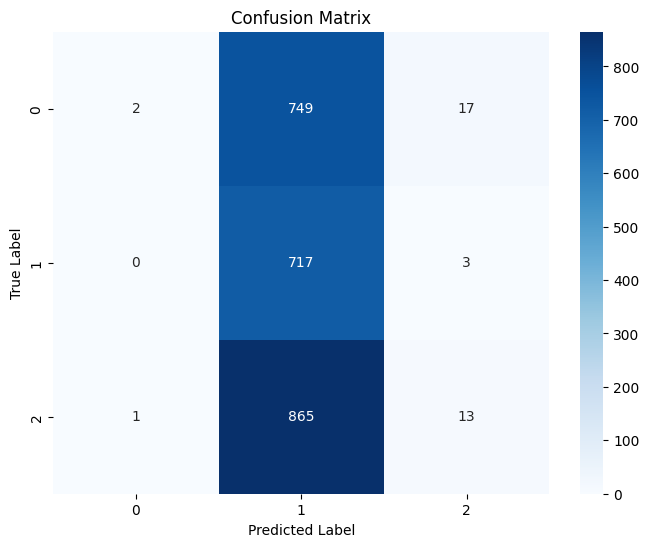

In [56]:
# Create the testing confusion matrix
cm = confusion_matrix(test_df['gold_label'], test_df['predicted_label'])

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d",cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [57]:
report_dict = classification_report(test_df['gold_label'], test_df['predicted_label'], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose() 
report_df.columns.name = 'label'
report_df

label,precision,recall,f1-score,support
C,0.666667,0.002604,0.005188,768.000000
E,0.307593,0.995833,0.470010,720.000000
N,0.393939,0.014790,0.028509,879.000000
accuracy,0.309252,0.309252,0.309252,0.309252
macro avg,0.456066,0.337742,0.167902,2367.000000
weighted avg,0.456164,0.309252,0.155239,2367.000000


In [58]:
def compute_metrics_by_type(group):
    predictions = group['gold_label']
    labels = group['predicted_label']
    acc = np.mean(predictions == labels)
    precision = precision_score(labels, predictions,average="weighted")
    recall = recall_score(labels, predictions,average="weighted")
    f1 = f1_score(labels, predictions,average="weighted")
    return pd.Series({'accuracy': round(acc,2), 'precision': round(precision,2), 'recall': round(recall,2), 'f1_score': round(f1,2)})

In [59]:
metrics_by_type = test_df.groupby('type').apply(compute_metrics_by_type).reset_index()
metrics_by_type.columns.name = 'ID'
metrics_by_type

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

ID,type,accuracy,precision,recall,f1_score
0,type1_again,0.00,0.00,0.00,0.00
1,type1_possessive,0.00,0.00,0.00,0.00
2,type2_again,0.02,0.00,0.02,0.00
3,type2_possessive,0.00,0.00,0.00,0.00
4,type3_again,0.11,0.96,0.11,0.14
5,type3_possessive,0.00,0.00,0.00,0.00
6,type4_possessive,0.26,0.98,0.26,0.40
7,type5_again,0.93,0.98,0.93,0.96
8,type5_possessive,0.64,1.00,0.64,0.78
